lol, err: invalid literal for int() with base 10: '-'


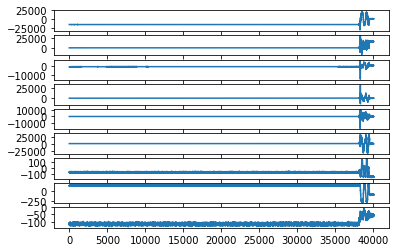

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re

def match_to_tuple(string):
    parts = string.split(',')
    return (int(parts[0]), int(parts[1]), int(parts[2]))

log = []
freq = None

with open('log.txt', 'r', encoding='latin-1') as f:
    for line in f:
        if 'MZ' not in line:
            continue
        parts = line.split(';')
        cool_parts = [p for p in parts if (('MZ:' in p)
                                           or ('ac:' in p)
                                           or ('g:' in p)
                                           or ('mg:' in p))]
        try:
            t = int(cool_parts[0].split(':')[1].strip())
            ac = match_to_tuple(cool_parts[1].split(':')[1].strip()[1:-1])
            g = match_to_tuple(cool_parts[2].split(':')[1].strip()[1:-1])
            mg = match_to_tuple(cool_parts[3].split(':')[1].strip()[1:-1])
            log.append((t, ac, g, mg))
        except Exception as e:
            print('lol, err: {}'.format(e))

acc_x = list(map(lambda x: x[1][0], log))
acc_y = list(map(lambda x: x[1][1], log))
acc_z = list(map(lambda x: x[1][2], log))

gyro_x = list(map(lambda x: x[2][0], log))
gyro_y = list(map(lambda x: x[2][1], log))
gyro_z = list(map(lambda x: x[2][2], log))

mag_x = list(map(lambda x: x[3][0], log))
mag_y = list(map(lambda x: x[3][1], log))
mag_z = list(map(lambda x: x[3][2], log))

f, axarr = plt.subplots(9, sharex=True)

axarr[0].plot(acc_x)
axarr[1].plot(acc_y)
axarr[2].plot(acc_z)
axarr[3].plot(gyro_x)
axarr[4].plot(gyro_y)
axarr[5].plot(gyro_z)
axarr[6].plot(mag_x)
axarr[7].plot(mag_y)
axarr[8].plot(mag_z)

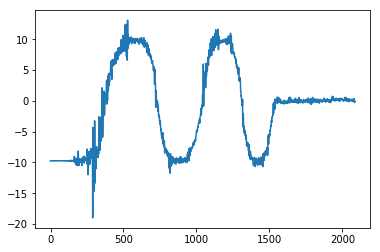

In [3]:
dps = 250.0
d2r = 3.14159265359 / 180.0

gyro_scale = dps / 32767.5 * d2r
gyro_x = np.array(gyro_x) * gyro_scale
gyro_y = np.array(gyro_y) * gyro_scale
gyro_z = np.array(gyro_z) * gyro_scale

acc_scale = 9.807 * 2.0 / 32767.5
acc_x = np.array(acc_x) * acc_scale
acc_y = np.array(acc_y) * acc_scale
acc_z = np.array(acc_z) * acc_scale

mag_factory_x = 177
mag_factory_y = 179
mag_factory_z = 167

mag_scale_x = ((float(mag_factory_x) - 128.0) / 256.0 + 1.0) * 4912.0 / 32760.0
mag_scale_y = ((float(mag_factory_y) - 128.0) / 256.0 + 1.0) * 4912.0 / 32760.0
mag_scale_z = ((float(mag_factory_z) - 128.0) / 256.0 + 1.0) * 4912.0 / 32760.0

mag_x = np.array(mag_x) * mag_scale_x
mag_y = np.array(mag_y) * mag_scale_y
mag_z = np.array(mag_z) * mag_scale_z

plt.plot(acc_x[38000:])

In [2]:
# Source: https://github.com/morgil/madgwick_py

import warnings
import numpy as np
from numpy.linalg import norm

import numpy as np
import numbers


class Quaternion:
    """
    A simple class implementing basic quaternion arithmetic.
    """
    def __init__(self, w_or_q, x=None, y=None, z=None):
        """
        Initializes a Quaternion object
        :param w_or_q: A scalar representing the real part of the quaternion, another Quaternion object or a
                    four-element array containing the quaternion values
        :param x: The first imaginary part if w_or_q is a scalar
        :param y: The second imaginary part if w_or_q is a scalar
        :param z: The third imaginary part if w_or_q is a scalar
        """
        self._q = np.array([1, 0, 0, 0])

        if x is not None and y is not None and z is not None:
            w = w_or_q
            q = np.array([w, x, y, z])
        elif isinstance(w_or_q, Quaternion):
            q = np.array(w_or_q.q)
        else:
            q = np.array(w_or_q)
            if len(q) != 4:
                raise ValueError("Expecting a 4-element array or w x y z as parameters")

        self._set_q(q)

    # Quaternion specific interfaces

    def conj(self):
        """
        Returns the conjugate of the quaternion
        :rtype : Quaternion
        :return: the conjugate of the quaternion
        """
        return Quaternion(self._q[0], -self._q[1], -self._q[2], -self._q[3])

    def to_angle_axis(self):
        """
        Returns the quaternion's rotation represented by an Euler angle and axis.
        If the quaternion is the identity quaternion (1, 0, 0, 0), a rotation along the x axis with angle 0 is returned.
        :return: rad, x, y, z
        """
        if self[0] == 1 and self[1] == 0 and self[2] == 0 and self[3] == 0:
            return 0, 1, 0, 0
        rad = np.arccos(self[0]) * 2
        imaginary_factor = np.sin(rad / 2)
        if abs(imaginary_factor) < 1e-8:
            return 0, 1, 0, 0
        x = self._q[1] / imaginary_factor
        y = self._q[2] / imaginary_factor
        z = self._q[3] / imaginary_factor
        return rad, x, y, z

    @staticmethod
    def from_angle_axis(rad, x, y, z):
        s = np.sin(rad / 2)
        return Quaternion(np.cos(rad / 2), x*s, y*s, z*s)

    def to_euler_angles(self):
        pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
        if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
            roll = 0
            yaw = 2 * np.arctan2(self[1], self[0])
        elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
            roll = -2 * np.arctan2(self[1], self[0])
            yaw = 0
        else:
            roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
            yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
        return roll, pitch, yaw

    def to_euler123(self):
        roll = np.arctan2(-2*(self[2]*self[3] - self[0]*self[1]), self[0]**2 - self[1]**2 - self[2]**2 + self[3]**2)
        pitch = np.arcsin(2*(self[1]*self[3] + self[0]*self[1]))
        yaw = np.arctan2(-2*(self[1]*self[2] - self[0]*self[3]), self[0]**2 + self[1]**2 - self[2]**2 - self[3]**2)
        return roll, pitch, yaw

    def __mul__(self, other):
        """
        multiply the given quaternion with another quaternion or a scalar
        :param other: a Quaternion object or a number
        :return:
        """
        if isinstance(other, Quaternion):
            w = self._q[0]*other._q[0] - self._q[1]*other._q[1] - self._q[2]*other._q[2] - self._q[3]*other._q[3]
            x = self._q[0]*other._q[1] + self._q[1]*other._q[0] + self._q[2]*other._q[3] - self._q[3]*other._q[2]
            y = self._q[0]*other._q[2] - self._q[1]*other._q[3] + self._q[2]*other._q[0] + self._q[3]*other._q[1]
            z = self._q[0]*other._q[3] + self._q[1]*other._q[2] - self._q[2]*other._q[1] + self._q[3]*other._q[0]

            return Quaternion(w, x, y, z)
        elif isinstance(other, numbers.Number):
            q = self._q * other
            return Quaternion(q)

    def __add__(self, other):
        """
        add two quaternions element-wise or add a scalar to each element of the quaternion
        :param other:
        :return:
        """
        if not isinstance(other, Quaternion):
            if len(other) != 4:
                raise TypeError("Quaternions must be added to other quaternions or a 4-element array")
            q = self.q + other
        else:
            q = self.q + other.q

        return Quaternion(q)

    # Implementing other interfaces to ease working with the class

    def _set_q(self, q):
        self._q = q

    def _get_q(self):
        return self._q

    q = property(_get_q, _set_q)

    def __getitem__(self, item):
        return self._q[item]

    def __array__(self):
        return self._q

class MadgwickAHRS:
    samplePeriod = 1/256
    quaternion = Quaternion(1, 0, 0, 0)
    beta = 1

    def __init__(self, sampleperiod=None, quaternion=None, beta=None):
        """
        Initialize the class with the given parameters.
        :param sampleperiod: The sample period
        :param quaternion: Initial quaternion
        :param beta: Algorithm gain beta
        :return:
        """
        if sampleperiod is not None:
            self.samplePeriod = sampleperiod
        if quaternion is not None:
            self.quaternion = quaternion
        if beta is not None:
            self.beta = beta

    def update(self, gyroscope, accelerometer, magnetometer):
        """
        Perform one update step with data from a AHRS sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        :param magnetometer: A three-element array containing the magnetometer data. Can be any unit since a normalized value is used.
        :return:
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()
        magnetometer = np.array(magnetometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Normalise magnetometer measurement
        if norm(magnetometer) is 0:
            warnings.warn("magnetometer is zero")
            return
        magnetometer /= norm(magnetometer)

        h = q * (Quaternion(0, magnetometer[0], magnetometer[1], magnetometer[2]) * q.conj())
        b = np.array([0, norm(h[1:3]), 0, h[3]])

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2],
            2*b[1]*(0.5 - q[2]**2 - q[3]**2) + 2*b[3]*(q[1]*q[3] - q[0]*q[2]) - magnetometer[0],
            2*b[1]*(q[1]*q[2] - q[0]*q[3]) + 2*b[3]*(q[0]*q[1] + q[2]*q[3]) - magnetometer[1],
            2*b[1]*(q[0]*q[2] + q[1]*q[3]) + 2*b[3]*(0.5 - q[1]**2 - q[2]**2) - magnetometer[2]
        ])
        j = np.array([
            [-2*q[2],                  2*q[3],                  -2*q[0],                  2*q[1]],
            [2*q[1],                   2*q[0],                  2*q[3],                   2*q[2]],
            [0,                        -4*q[1],                 -4*q[2],                  0],
            [-2*b[3]*q[2],             2*b[3]*q[3],             -4*b[1]*q[2]-2*b[3]*q[0], -4*b[1]*q[3]+2*b[3]*q[1]],
            [-2*b[1]*q[3]+2*b[3]*q[1], 2*b[1]*q[2]+2*b[3]*q[0], 2*b[1]*q[1]+2*b[3]*q[3],  -2*b[1]*q[0]+2*b[3]*q[2]],
            [2*b[1]*q[2],              2*b[1]*q[3]-4*b[3]*q[1], 2*b[1]*q[0]-4*b[3]*q[2],  2*b[1]*q[1]]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

    def update_imu(self, gyroscope, accelerometer):
        """
        Perform one update step with data from a IMU sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2]
        ])
        j = np.array([
            [-2*q[2], 2*q[3], -2*q[0], 2*q[1]],
            [2*q[1], 2*q[0], 2*q[3], 2*q[2]],
            [0, -4*q[1], -4*q[2], 0]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q)) # normalise quaternion

In [159]:
ahrs = MadgwickAHRS(sampleperiod = 0.00701825)
quats = []
for i in range(len(log)):
    # TODO: understand frames of reference for mag/acc/madgwick
    ahrs.update(np.array([gyro_x[i], gyro_y[i], gyro_z[i]]),
               np.array([acc_x[i], acc_y[i], acc_z[i]]),
               np.array([mag_x[i], mag_y[i], -mag_z[i]]))
    quats.append(ahrs.quaternion)

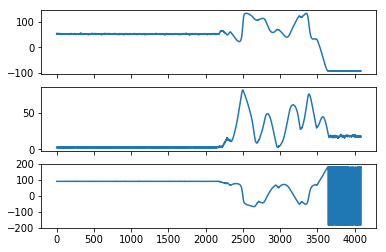

In [160]:
angles = list(map(lambda x: x.to_euler_angles(), quats))
roll = list(map(lambda x: x[0], angles))
pitch = list(map(lambda x: x[1], angles))
yaw = list(map(lambda x: x[2], angles))

f, axarr = plt.subplots(3, sharex=True)

axarr[0].plot(np.degrees(roll)[36000:])
axarr[1].plot(np.degrees(pitch)[36000:])
axarr[2].plot(np.degrees(yaw)[36000:])

In [42]:
phi = np.arctan2(acc_y, np.sqrt(np.power(acc_x, 2.0) + np.power(acc_z, 2.0)))
theta = np.arctan2(-acc_x, np.sqrt(np.power(acc_y, 2.0) + np.power(acc_z, 2.0)))
time = list(map(lambda x: x[0] / 64000000, log))

phi_hat = 0.0
theta_hat = 0.0

N = 200
offset_phi = np.sum(phi[:N]) / len(phi[:N])
offset_theta = np.sum(theta[:N]) / len(theta[:N])
print("Offsets: {} {}".format(offset_phi, offset_theta))

prev_ts = time[0]

s_e = np.array([[0], [0], [0], [0]])
C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
P = np.eye(4)
Q = np.eye(4)
R = np.eye(2)

phi_pred = []
theta_pred = []

for i, ts in enumerate(time[1:]):
    dt = ts - prev_ts
    prev_ts = ts
    phi_s = phi[i] - offset_phi
    theta_s = theta[i] - offset_theta
    p = gyro_x[i]
    q = gyro_y[i]
    r = gyro_z[i]

    phi_dot = p + np.sin(phi_hat) * np.tan(theta_hat) * q + np.cos(phi_hat) * np.tan(theta_hat) * r
    theta_dot = np.cos(phi_hat) * q - np.sin(phi_hat) * r

    A = np.array([[1, -dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, -dt], [0, 0, 0, 1]])
    B = np.array([[dt, 0], [0, 0], [0, dt], [0, 0]])

    g_s = np.array([[phi_dot], [theta_dot]])

    s_e = A.dot(s_e)
    s_e = s_e + B.dot(g_s)
    P = A.dot(P.dot(np.transpose(A))) + Q

    a_s = np.array([[phi_s], [theta_s]])
    y_t = a_s - C.dot(s_e)
    S = R + C.dot(P.dot(np.transpose(C)))
    K = P.dot(np.transpose(C).dot(np.linalg.inv(S)))
    s_e = s_e + K.dot(y_t)
    P = (np.eye(4) - K.dot(C)).dot(P)
    phi_hat = s_e[0][0]
    theta_hat = s_e[2][0]
    phi_pred.append(phi_hat)
    theta_pred.append(theta_hat)

Offsets: 0.03577712601651312 1.5157900633154628


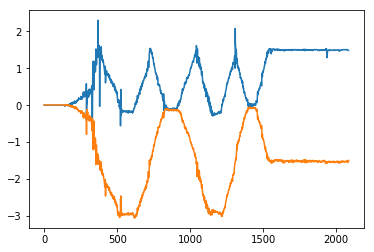

In [41]:
plt.plot(phi_pred[38000:])
plt.plot(theta_pred[38000:])